# Prior-Only and Action-Aware Blind baselines

In [3]:
cd ../../

/mnt/sda/otani/Experiments/hidden-challenges-MR


In [4]:
import matplotlib as mpl
from typing import List
import json
from multiprocessing import Pool
import numpy as np
import spacy
import matplotlib.pyplot as plt
from src.toolbox.utils import sentence2token, _load_top_actions
from src.toolbox.eval import evaluate, accumulate_metrics
from src.toolbox.visualization import plot_performance_per_duration
from src.toolbox.data_converters import ActivityNetCap2Instances
from src.toolbox.baseline import SegmentGeneratorKDE, predict
import seaborn as sns
sns.set_style("white")

In [5]:
raw_data = json.load(open("data/raw/activitynet/train.json"))
train_data = ActivityNetCap2Instances(raw_data)

prior_only_generator = SegmentGeneratorKDE()
prior_only_generator.fit("base", train_data)

#instances: 37421


In [6]:
def parse_tokens(data):
    sentences = [query[1] for query, _ in data]
    n_cpus = multi.cpu_count()
    with Pool(n_cpus) as p:
        tokens = p.map(sentence2token, sentences, len(sentences)//n_cpus)
    return tokens

%time tokens = parse_tokens(train_data)

CPU times: user 184 ms, sys: 104 ms, total: 288 ms
Wall time: 33.7 s


In [7]:
top_actions = _load_top_actions("activitynet")
action_aware_generator = SegmentGeneratorKDE()
for action in top_actions:
    indices = [i for i, query in enumerate(tokens) if action in query[0]]
    sub_train = [train_data[i] for i in indices]
    action_aware_generator.fit(action, sub_train)
action_aware_generator.fit("base", train_data)

#instances: 3930
#instances: 2589
#instances: 2475
#instances: 2354
#instances: 2004
#instances: 1918
#instances: 1787
#instances: 1741
#instances: 1672
#instances: 1504
#instances: 1242
#instances: 1129
#instances: 1109
#instances: 1041
#instances: 1008
#instances: 952
#instances: 908
#instances: 839
#instances: 812
#instances: 801
#instances: 767
#instances: 774
#instances: 757
#instances: 736
#instances: 723
#instances: 710
#instances: 655
#instances: 647
#instances: 592
#instances: 578
#instances: 567
#instances: 536
#instances: 527
#instances: 517
#instances: 502
#instances: 450
#instances: 451
#instances: 443
#instances: 395
#instances: 391
#instances: 391
#instances: 385
#instances: 375
#instances: 373
#instances: 371
#instances: 350
#instances: 333
#instances: 347
#instances: 339
#instances: 326
#instances: 37421


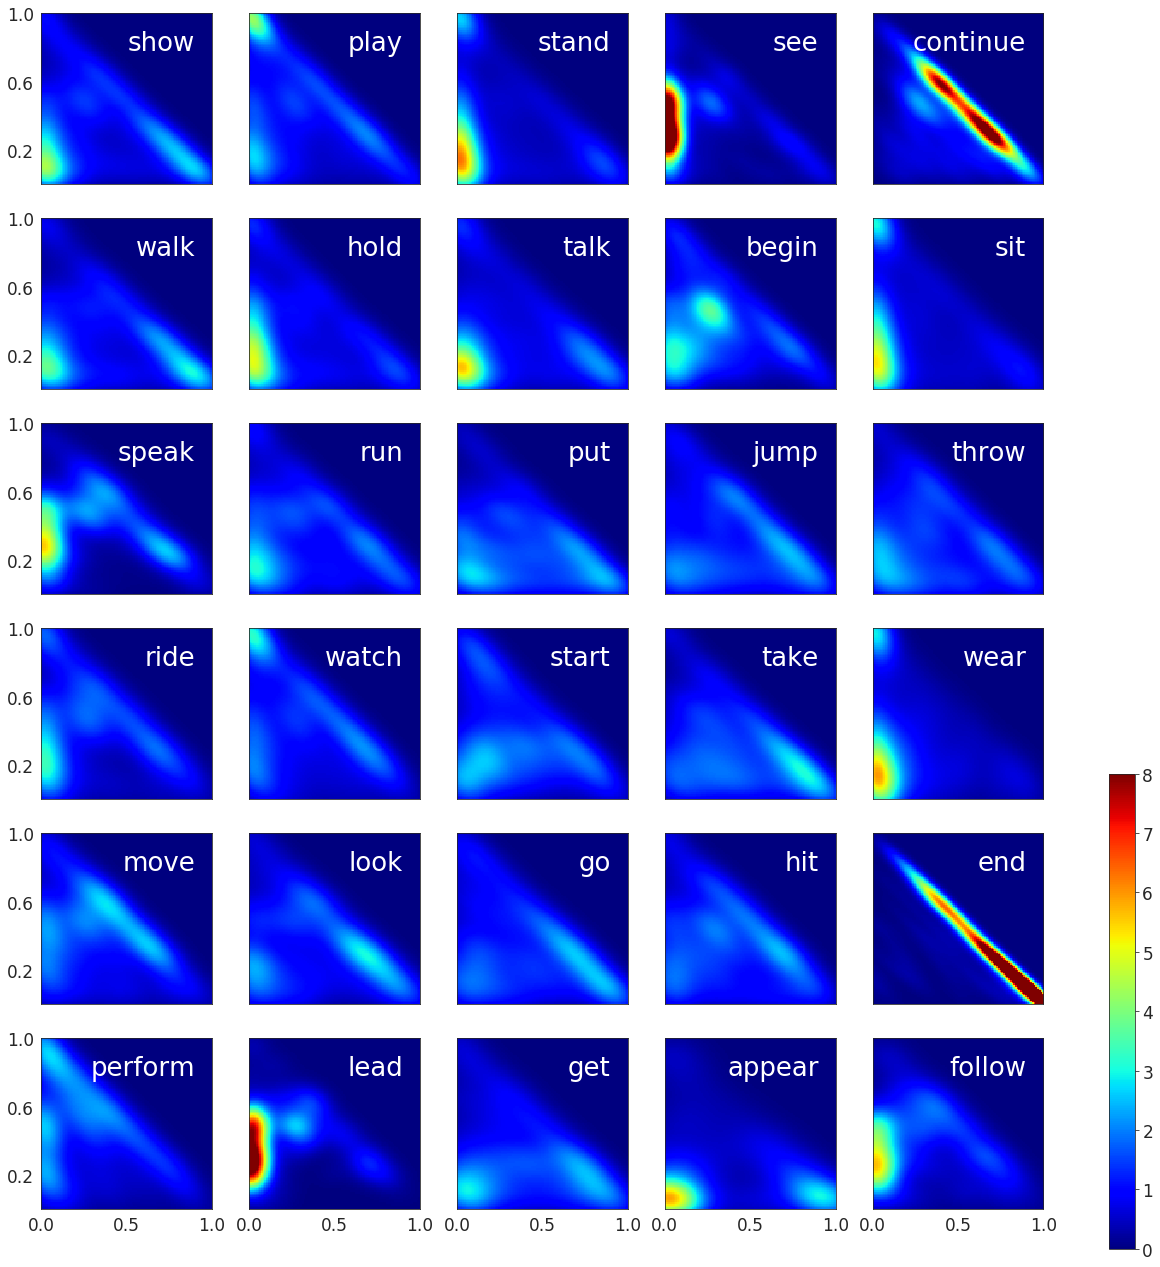

In [8]:
with mpl.rc_context(rc={'font.size': 17}):
    f, axes = plt.subplots(6, 5, figsize=(18, 22))
    axes = axes.ravel()
    for i, (action, kernel) in enumerate(action_aware_generator.kernels.items()):
        if i==len(axes):
            break
        X, Y = np.mgrid[0:1:100j, 0:1:100j]
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = np.reshape(kernel(positions).T, X.shape)
        im = axes[i].imshow(np.rot90(Z), cmap=plt.cm.jet, extent=[0, 1, 0, 1], vmin=0, vmax=8)
        axes[i].text(0.9, 0.9, action, ha='right', va='top', color='w', fontsize=26)
        axes[i].grid(False)
        axes[i].set_yticks([0.2, 0.6, 1.0])
        axes[i].set_xticks([0.0, 0.5, 1.0])

        if i%5:
            axes[i].set_yticks([])
        if i<25:
            axes[i].set_xticks([])
    cbar_ax = f.add_axes([0.95, 0.1, 0.02, 0.3])#[left, bottom, width, height]
    f.colorbar(im, cax=cbar_ax)
    plt.savefig(f"reports/figures/dataset-visualization/activitynet-moment-prior.pdf", bbox_inches="tight")

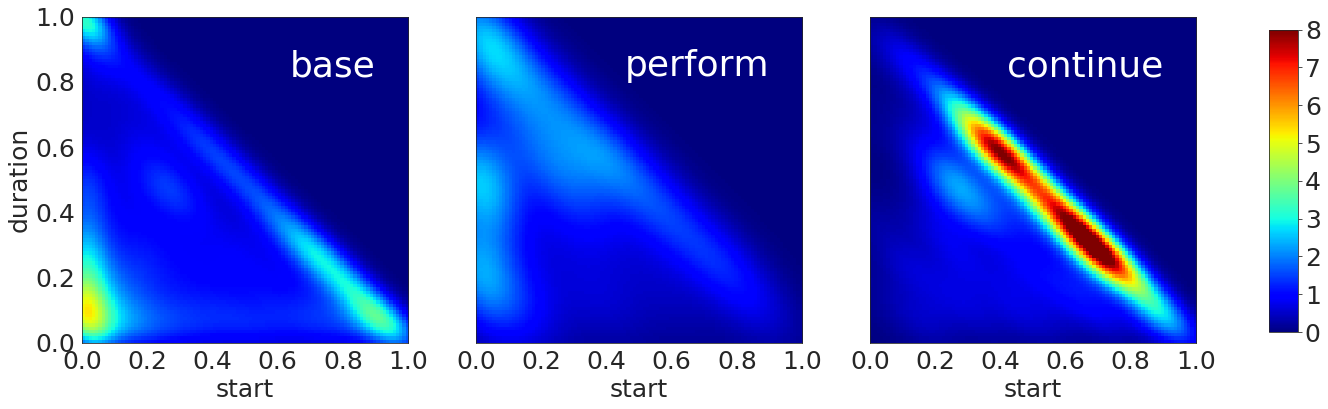

In [9]:
with mpl.rc_context(rc={'font.size': 25}):
    f, axes = plt.subplots(1, 3, figsize=(20, 6))
    axes = axes.ravel()
    for i, action in enumerate(['base', 'perform', 'continue']):
        kernel = action_aware_generator.kernels[action]
        if i==len(axes):
            break
        X, Y = np.mgrid[0:1:100j, 0:1:100j]
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = np.reshape(kernel(positions).T, X.shape)
        im = axes[i].imshow(np.rot90(Z), cmap=plt.cm.jet, extent=[0, 1, 0, 1], vmin=0, vmax=8)
        axes[i].text(0.9, 0.9, action, ha='right', va='top', color='w', fontsize=36)
        axes[i].grid(False)
        axes[i].set_xlabel('start')

        if i>0:
            axes[i].set_yticks([])
        else:
            axes[i].set_ylabel('duration')
            
    cbar_ax = f.add_axes([0.95, 0.15, 0.02, 0.7])#[left, bottom, width, height]
    f.colorbar(im, cax=cbar_ax)
    plt.savefig(f"reports/figures/dataset-visualization/activitynet-moment-prior_(base,perform,continue).pdf", bbox_inches="tight")

# Test blind baselines

In [10]:
raw_data = json.load(open("data/raw/activitynet/val_2.json"))
test_data = ActivityNetCap2Instances(raw_data)

In [11]:
# action-agnostic baseline
action_agnostic_predictions = predict(prior_only_generator, test_data, 0.45)
action_agnostic_results = evaluate(test_data, action_agnostic_predictions)
action_agnostic_summary = accumulate_metrics(action_agnostic_results)
f"{action_agnostic_summary['R@1 IoU>0.5'] * 100:.2f}"

evaluating: 100%|██████████| 17031/17031 [00:16<00:00, 1057.06it/s]


R@1 IoU>0.3 0.19
R@1 IoU>0.5 0.11
R@1 IoU>0.7 0.04
R@5 IoU>0.3 0.49
R@5 IoU>0.5 0.30
R@5 IoU>0.7 0.14
R@10 IoU>0.3 0.83
R@10 IoU>0.5 0.62
R@10 IoU>0.7 0.32


'10.80'

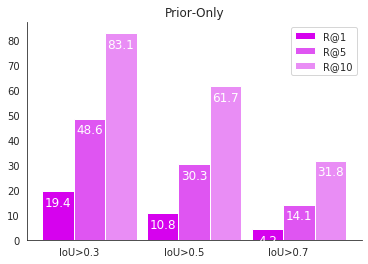

In [12]:
def display_score(bar, color="w"):
    plt.text(
        bar.get_x()+bar.get_width()*.5,
        bar.get_height()-6,
        f"{bar.get_height():.1f}",
        horizontalalignment="center",
        fontsize=12,
        color=color
    )

from typing import Dict, Optional

def plot_performance_summary(summary: Dict[str, float], title: Optional[str] = None):
    plt.figure(figsize=(6, 4))
    c = ["#d602ee", "#df55f2", "#e98df5"]
    labels = ["Original", "Randomized"]
    keys = [f"R@{k} IoU>0.5" for k in [1, 5, 10]]
    x = np.arange(3)+0.2

    for metric in ["R@1", "R@5", "R@10"]:
        vals = [summary[k] * 100 for k in summary.keys() if k.split()[0]==metric]
        bars = plt.bar(x, vals, width=0.3, color=c.pop(0), label=metric)
        for b in bars:
            display_score(b, color="w")
        x += 0.3
        
    plt.xticks(
        ticks=np.arange(3)+0.4,
        labels=["IoU>0.3", "IoU>0.5", "IoU>0.7"],
        ha="center")
        
    plt.legend()
    if title is not None:
        plt.title(title)
    sns.despine(left=False)

plot_performance_summary(action_agnostic_summary, title="Prior-Only")

In [13]:
# use only first seen verb
action_aware_predictions = predict(action_aware_generator, test_data, 0.45)
action_aware_results = evaluate(test_data, action_aware_predictions)
action_aware_summary = accumulate_metrics(action_aware_results)
f"{action_aware_summary['R@1 IoU>0.5'] * 100:.2f}"

evaluating: 100%|██████████| 17031/17031 [00:15<00:00, 1088.92it/s]


R@1 IoU>0.3 0.35
R@1 IoU>0.5 0.24
R@1 IoU>0.7 0.13
R@5 IoU>0.3 0.62
R@5 IoU>0.5 0.47
R@5 IoU>0.7 0.26
R@10 IoU>0.3 0.84
R@10 IoU>0.5 0.68
R@10 IoU>0.7 0.39


'24.30'

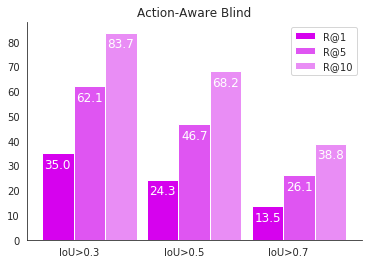

In [14]:
plot_performance_summary(action_aware_summary, title="Action-Aware Blind")

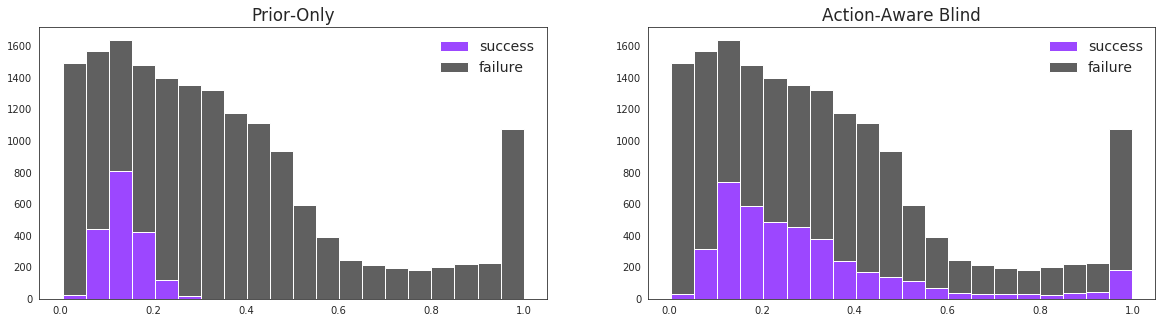

In [15]:
from src.toolbox.visualization import plot_performance_per_duration

f, axes = plt.subplots(1, 2, figsize=(20, 5))
plt.rcParams.update({'font.size': 14})
_ = plot_performance_per_duration(action_agnostic_results, test_data, ax=axes[0])
axes[0].set_title("Prior-Only")
_ = plot_performance_per_duration(action_aware_results, test_data, ax=axes[1])
axes[1].set_title("Action-Aware Blind")
plt.savefig("reports/figures/performance-analysis/charades/performance_per_duration_blindbaselines.pdf", bbox_inches="tight")